## Методические указания по выполнению лабораторной работы №2

**Тема: Fine-tuning предобученной модели ResNeXt для классификации изображений**

**Цель работы:** Ознакомиться с архитектурой ResNeXt, её отличительными особенностями и научиться проводить fine-tuning предобученной модели ResNeXt на новом датасете.

**Задачи:**
- Изучить теоретическую базу архитектуры ResNeXt и понять её отличие от классической ResNet.
- Ознакомиться с особенностями датасета CIFAR-100
- Загрузить предобученную модель ResNeXt
- Заменить последний полносвязный слой для адаптации модели к новому числу классов
- Провести fine-tuning модели на выбранном датасете
- Визуализировать динамику обучения (например, выводить значение потерь по эпохам)
- Выполнить оценку модели на тестовом наборе с построением отчёта по метрикам и матрицы ошибок
- Визуализировать предсказания и проанализировать ошибки модели

### 1. Теоретическая часть

В данной лабораторной работе мы будем проводить легкий fine-tuning - адаптацию обученной модели к работе на других данных. Для задачи классификации будем применять архитектуру [ResNeXt](https://arxiv.org/pdf/1611.05431), обученную на наборе данных [ImageNet](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description), а для запуска прогнозов модели воспользуемся набором данных [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html). Для выполнения работы вам понадобится ознакомиться с документацией фреймфорка для создания нейросетевых моделей [PyTorch](https://pytorch.org/docs/stable/index.html), в дальнейшем вы будете часто обращаться к ней.

**Перед тем, как приступать к выполнению практической части, ознакомьтесь с первоисточниками используемых компонентов и изучите их содержание и структуру.**

#### 1.1 Архитектура ResNeXt
ResNeXt – это развитие архитектуры ResNet, представленное в работе «Aggregated Residual Transformations for Deep Neural Networks» (Xie et al., 2017). Ключевые особенности:

Групповые свёртки: вместо использования стандартной свёртки в каждом residual-блоке применяется группированная свёртка, которая делит входные каналы на несколько групп. Каждая группа обрабатывается независимо, а затем результаты объединяются. Это позволяет увеличить "cardinality" (число параллельных путей) без значительного увеличения количества параметров.

Cardinality: это количество групп в групповых свёртках. Увеличение cardinality позволяет модели извлекать более разнообразные признаки, улучшая её выразительную способность, что часто приводит к повышению качества классификации при сохранении вычислительной эффективности.

Остаточные соединения: как и в ResNet, в ResNeXt используются skip-соединения, позволяющие градиенту свободно распространяться по сети, что облегчает обучение глубоких архитектур.

Разные конфигурации ResNeXt:
В зависимости от требований к точности и вычислительным ресурсам, архитектура ResNeXt предлагается в нескольких конфигурациях. Основными параметрами являются глубина сети, количество групп (cardinality) и «ширина» каждой группы (обычно указывается в виде, например, 32x4d или 32x8d):

    ResNeXt-50 (32x4d): В этой конфигурации сеть имеет 50 слоёв, cardinality равную 32 и «ширину» групп – 4 (то есть каждая группа имеет 4 свёрточных фильтра). Такая конфигурация является хорошим компромиссом между производительностью и вычислительной эффективностью для многих практических задач.

    ResNeXt-101 (32x8d): Здесь используется более глубокая сеть (101 слой) с тем же количеством групп (32), но увеличенной шириной групп – 8 фильтров на группу. Эта конфигурация позволяет добиться более высокой точности, однако требует больше вычислительных ресурсов и памяти.

    Существуют и другие конфигурации, например, с различными комбинациями глубины, cardinality и ширины групп. Выбор конкретной конфигурации зависит от задачи, объёма данных и вычислительных возможностей, позволяя исследователям и разработчикам выбирать оптимальную архитектуру в зависимости от конкретных требований к скорости, точности и ресурсам.

#### 1.2 Fine-tuning (дообучение) предобученной модели
Fine-tuning – это процесс адаптации модели, обученной на одном большом датасете, для решения другой, смежной задачи с иным числом классов или другими особенностями данных.

Виды Fine-tuning:

Feature Extraction (извлечение признаков): При данном подходе все слои модели, кроме последнего классификационного, замораживаются (их веса не обновляются), а последний слой заменяется и обучается на новом датасете. Этот метод подходит, когда объём данных невелик.

Полное Fine-tuning: В этом случае обновляются веса всех слоёв модели. Обычно применяется, если новый датасет достаточно велик или существенно отличается от исходного.

Частичное Fine-tuning: Некоторые слои (обычно верхние, ближе к выходу) обновляются, а остальные остаются замороженными.

В нашем случае применяется подход замены последнего полносвязного слоя, чтобы адаптировать модель к новому числу классов, а затем обучить всю модель с пониженным learning rate для сохранения полезных признаков, извлечённых при обучении на ImageNet. Таким образом, это не является чистым feature extraction, поскольку базовые признаки корректируются для улучшения качества классификации на целевом наборе данных.

#### 1.3 Оптимизатор и функция потерь
[Оптимизатор](https://pytorch.org/docs/stable/optim.html)

Оптимизатор отвечает за корректировку весов модели во время обратного распространения ошибки. Он определяет, как именно будут обновляться параметры модели на основе вычисленного градиента. Чтобы модель могла адаптироваться к новым данным, необходимо провести процесс обучения, в ходе которого происходит минимизация ошибки. Определение функции потерь и оптимизатора позволяет реализовать этот процесс.

[Функция потерь](https://pytorch.org/docs/stable/nn.html#loss-functions)

Функция потерь измеряет, насколько сильно предсказание модели отклоняется от истинных меток, и является ключевым элементом для оптимизации. Выбор конкретного оптимизатора и функции потерь влияет на стабильность и скорость сходимости модели. Это особенно важно при адаптации предобученной модели к новой задаче, где важно сохранить полезные представления и при этом обеспечить хорошее обобщение. Без функции потерь не было бы способа измерить качество предсказаний модели, а без оптимизатора – способа обновить её параметры для уменьшения этой ошибки. Это делает оба компонента неотъемлемой частью процесса обучения нейронных сетей.

### 2. Практическая часть

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [1]:
# импорт пакетов
import torch
from tqdm import tqdm
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Явно определите устройство для выполнения обучающих процедур и вычислений:

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

Используемое устройство: cuda


#### 2.2. Загрузка предобученной модели ResNeXt-50

Импортируйте предобученную модель ResNeXt в конфигурации 50 слоев, cardinality - 34 и "ширине" сверточных групп - 4.
Для этого обратитесь к пакету моделей и датасетов [torchvision](https://pytorch.org/vision/0.9/models.html) фреймфорка PyTorch. Там вы найдете сведения о работе с данными и моделью.

In [3]:
# импорт модели
model = models.resnext50_32x4d(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Следующим шагом необходимо заменить последний слой модели для возможности обучения на CIFAR-100 и перевести модель в режим обучения. Для этого проанализируйте код ниже и допишите недостающую часть.

Мы получаем число входных признаков (features), которое принимает последний полносвязный (fully connected) слой модели. Это значение необходимо, чтобы корректно создать новый классификационный слой, совместимый с предыдущей частью сети. Новый полносвязный слой создаётся с количеством входных нейронов, равным num_ftrs, и количеством выходных нейронов, равным 100 (для датасета CIFAR-100). Таким образом, последний слой, отвечающий за выдачу логитов классов, адаптируется под новую задачу.

In [4]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model = model.to(device)

# здесь будет перевод режима модели
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет из соответствующих пакетов PyTorch, предварительно определив метод трансформации данных для подачи в модель:

In [5]:
# объявите метод трансформации, включающий в себя изменение размера, приведение к тензору и нормализацию
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])
# загрузите датасет
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

#### 2.4 Настройка и обучение модели

После замены последнего слоя для завершения fine-tuning модели нужно определить как именно нейронная сеть будет обучаться. Для этого ниже мы определим важные параметры: функция потерь и оптимизатор.

В данной работе предлагается использовать оптимизатор **SGD** (Стохастический градиентный спуск) с параметром momentum, что помогает ускорить сходимость и стабилизировать процесс обучения. SGD является базовым и хорошо изученным алгоритмом, который часто используется для fine-tuning, особенно когда важна стабильность обновлений. Momentum позволяет ускорить обучение за счёт использования накопленной информации о направлении градиентов.

**CrossEntropyLoss** хорошо подходит для задач многоклассовой классификации, так как она оценивает разницу между распределением предсказаний и истинным распределением классов. В зависимости от специфики задачи можно выбрать и другие функции потерь, например, Focal Loss для несбалансированных данных.

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Проанализируйте приведенный ниже обучающий процесс.

Внешний цикл повторяется столько раз, сколько задано эпох **(1)**. *Задайте ее в значении не менее 3 и не более 10 в зависимости от доступных ресурсов.* Объявлется переменная для накопления суммарной ошибки и обнуляется в начале каждой эпохи **(2)**.

Внутренний цикл проходит по каждому батчу обучающего датасета, получаемому из объекта с обучающей выборкой **(3)**. На каждой итерации изображения и соответствующие им метки переводятся на устройство чтобы обеспечить совместимость вычислений **(4)**. Градиенты параметров модели накапливаются по умолчанию, поэтому перед началом нового батча их нужно обнулить чтобы предотвратить их смешивание от разных батчей **(5)**.
Производится прямой проход через модель, в результате чего получаются логиты (предсказания) **(6)** для каждого примера в батче. Функция потерь вычисляет расхождение **(7)** между предсказаниями модели и истинными метками. Обратное распространение ошибки рассчитывает градиенты функции потерь по параметрам модели **(8)**, что необходимо для последующего обновления весов. Оптимизатор обновляет веса нейронной сети **(9)** на основе вычисленных градиентов, двигаясь в направлении уменьшения функции потерь, и суммирует потери за батч, умноженные на количество примеров в этом батче **(10)** для возможности дальнейшего рассчета средней потери по всей эпохе. Подсчитывает среднюю потерю за эпоху **(11)**, что позволяет оценить, насколько хорошо модель обучается на протяжении всей эпохи.


In [7]:
num_epochs = 5   # 1

for epoch in tqdm(range(num_epochs)):
    log_template = "\nEpoch {epoch} train_loss: {epoch_loss:0.4f}"
    running_loss = 0.0   # 2
    for inputs, labels in train_loader:   # 3
        inputs, labels = inputs.to(device), labels.to(device)   # 4

        optimizer.zero_grad()   # 5
        outputs = model(inputs)   # 6
        loss = criterion(outputs, labels)   # 7
        loss.backward()   # 8
        optimizer.step()   # 9

        running_loss += loss.item() * inputs.size(0)   # 10

    epoch_loss = running_loss / len(train_dataset)   # 11

    # визуализируйте итеративный прогресс обучения и получаемое значение ошибки
    tqdm.write(log_template.format(epoch=epoch+1, epoch_loss=epoch_loss))


 20%|██        | 1/5 [12:30<50:02, 750.53s/it]


Epoch 1 train_loss: 1.3747


 40%|████      | 2/5 [24:57<37:25, 748.63s/it]


Epoch 2 train_loss: 0.5850


 60%|██████    | 3/5 [37:24<24:55, 747.83s/it]


Epoch 3 train_loss: 0.3538


 80%|████████  | 4/5 [49:54<12:28, 748.55s/it]


Epoch 4 train_loss: 0.2221


100%|██████████| 5/5 [1:02:24<00:00, 748.81s/it]


Epoch 5 train_loss: 0.1415


#### 2.5 Оценка модели и визуализация результатов

Определяем для каждого изображения класс CIFAR-100 с максимальной суммарной вероятностью.

В первую очередь необходимо перевести модель в режим инференса и объявить массивы истинных и прогнозных меток для последующего расчета метрик. Цикл оценки будет выполняться в блоке кода, в котором отключена возможность вычисления градиентов за отсутствием необходимости.

Аналогично прерыдущим этапам опишите цикл прохода по батчам тестового датасета. В нем будет выполняться прямой проход через модель для получения логитов (сырых предсказаний) для каждого примера в батче.

Используйте функцию **torch.max** аналогично 1 лабораторной работе для выбора максимального значения по измерению 1 (по столбцам), что соответствует наибольшей вероятности. Второй возвращаемый элемент – индексы максимальных значений, которые используются как предсказанные метки.

Преобразуйте полученные истинные и прогнозные метки в NumPy-массив и добавьте в соответствующие списки:

In [8]:
# переведите режим модели
model.eval()

# создайте списки для истинных и прогнозных меток
true_labels = []
pred_labels = []

with torch.no_grad():
    # напишите цикл предикта модели на тестовой выборке
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()

        true_labels.append(labels.cpu().numpy())
        pred_labels.append(predicted)

true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

Воспользуйтесь методом **classification_report** для расчета и вывода метрик модели и постройте матрицу ошибок инструментами визуализации данных

In [9]:
true_labels_txt = [train_dataset.classes[i] for i in true_labels]
pred_labels_txt = [train_dataset.classes[i] for i in pred_labels]

               precision    recall  f1-score   support

        apple       0.99      0.93      0.96       107
aquarium_fish       0.95      0.97      0.96        98
         baby       0.83      0.72      0.77       115
         bear       0.80      0.76      0.78       105
       beaver       0.64      0.81      0.72        79
          bed       0.82      0.87      0.85        94
          bee       0.84      0.92      0.88        91
       beetle       0.79      0.91      0.84        87
      bicycle       0.92      0.97      0.94        95
       bottle       0.95      0.93      0.94       102
         bowl       0.68      0.79      0.73        86
          boy       0.57      0.63      0.60        91
       bridge       0.87      0.81      0.84       107
          bus       0.87      0.84      0.86       103
    butterfly       0.91      0.82      0.86       111
        camel       0.88      0.85      0.87       103
          can       0.91      0.82      0.86       111
       ca

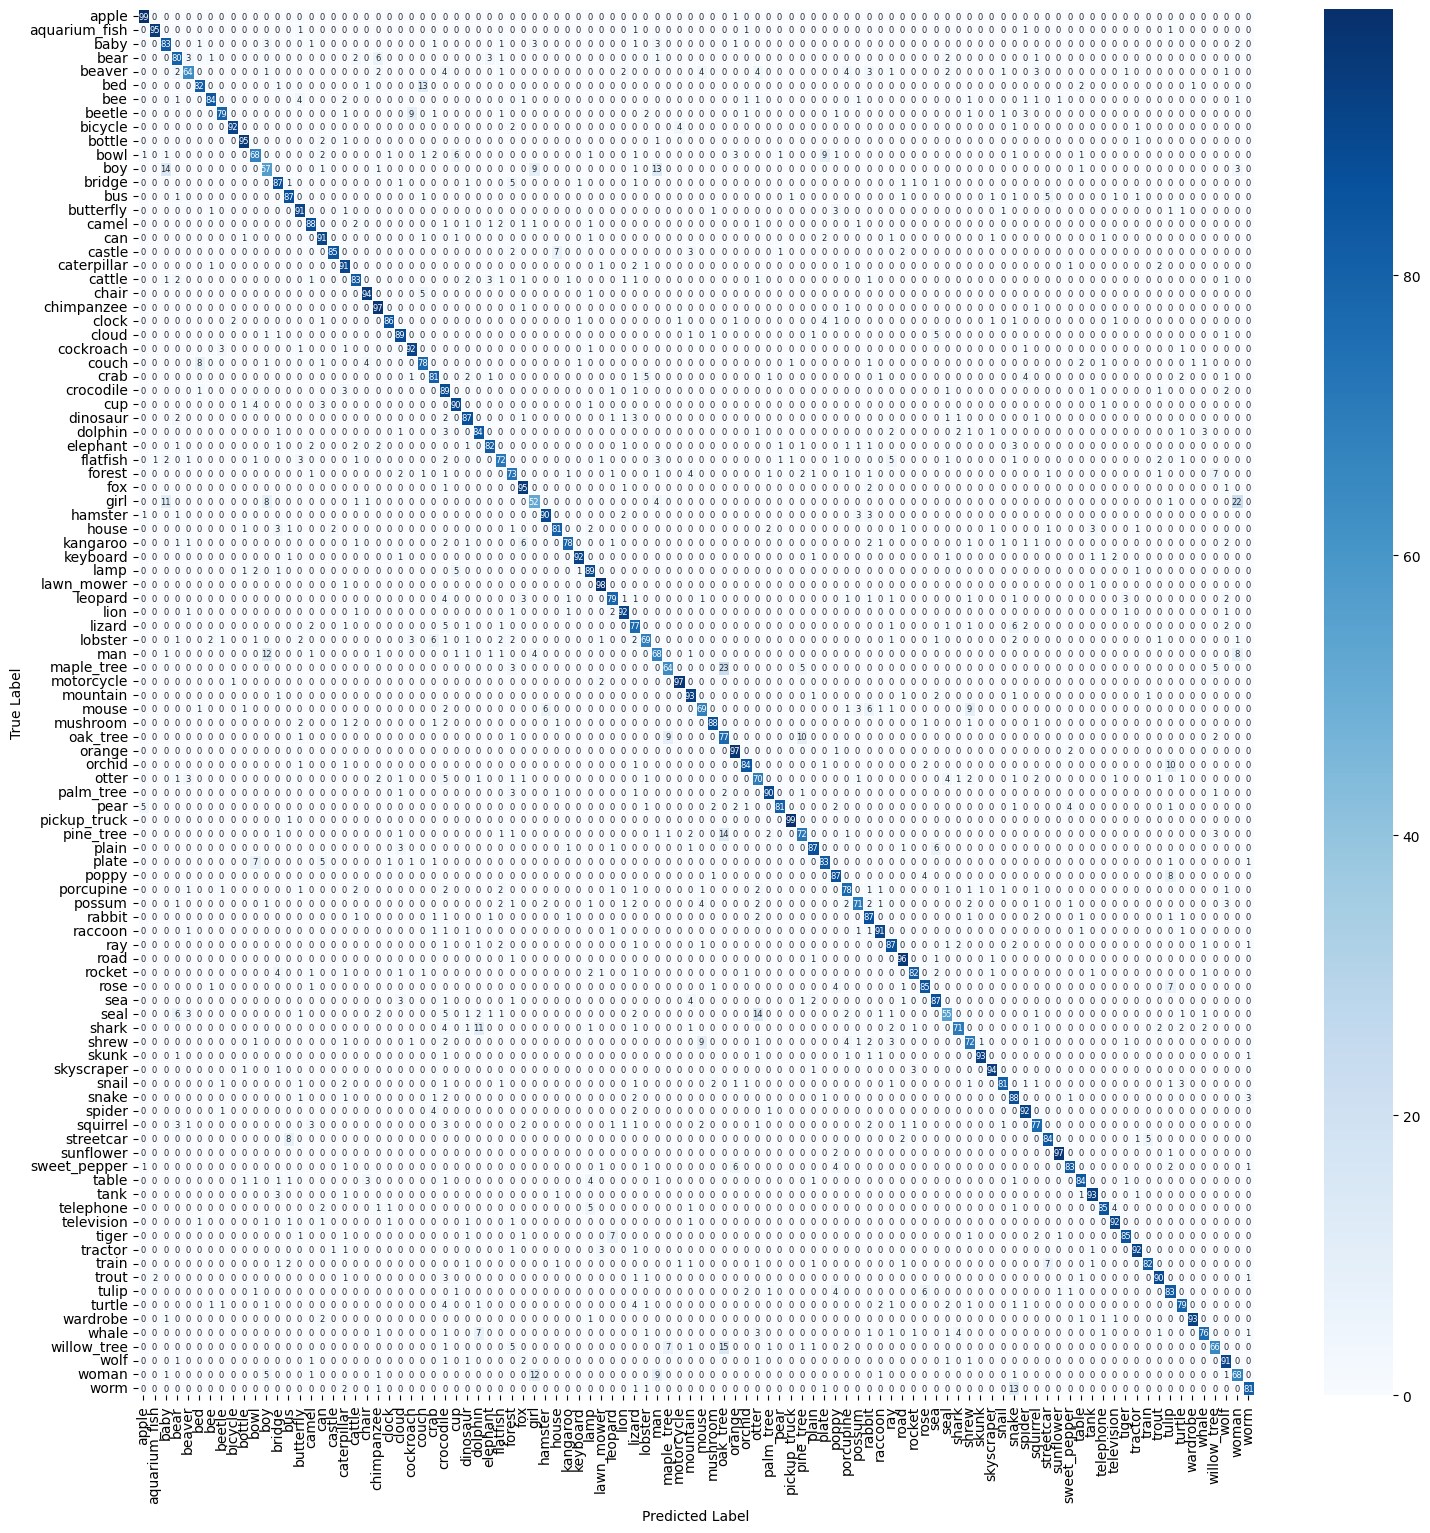

In [10]:
# расчитайте и выведите метрики
print(classification_report(pred_labels, true_labels, target_names=train_dataset.classes))

# постройте матрицу ошибок
cm = confusion_matrix(true_labels_txt, pred_labels_txt)
plt.figure(figsize=(18, 18))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                 annot_kws={"size": 6}, linewidths=0.5,
                 xticklabels=train_dataset.classes,
                 yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Визуализируйте предсказания модели на изображениях для одного батча, предварительно реализовав метод денормализации

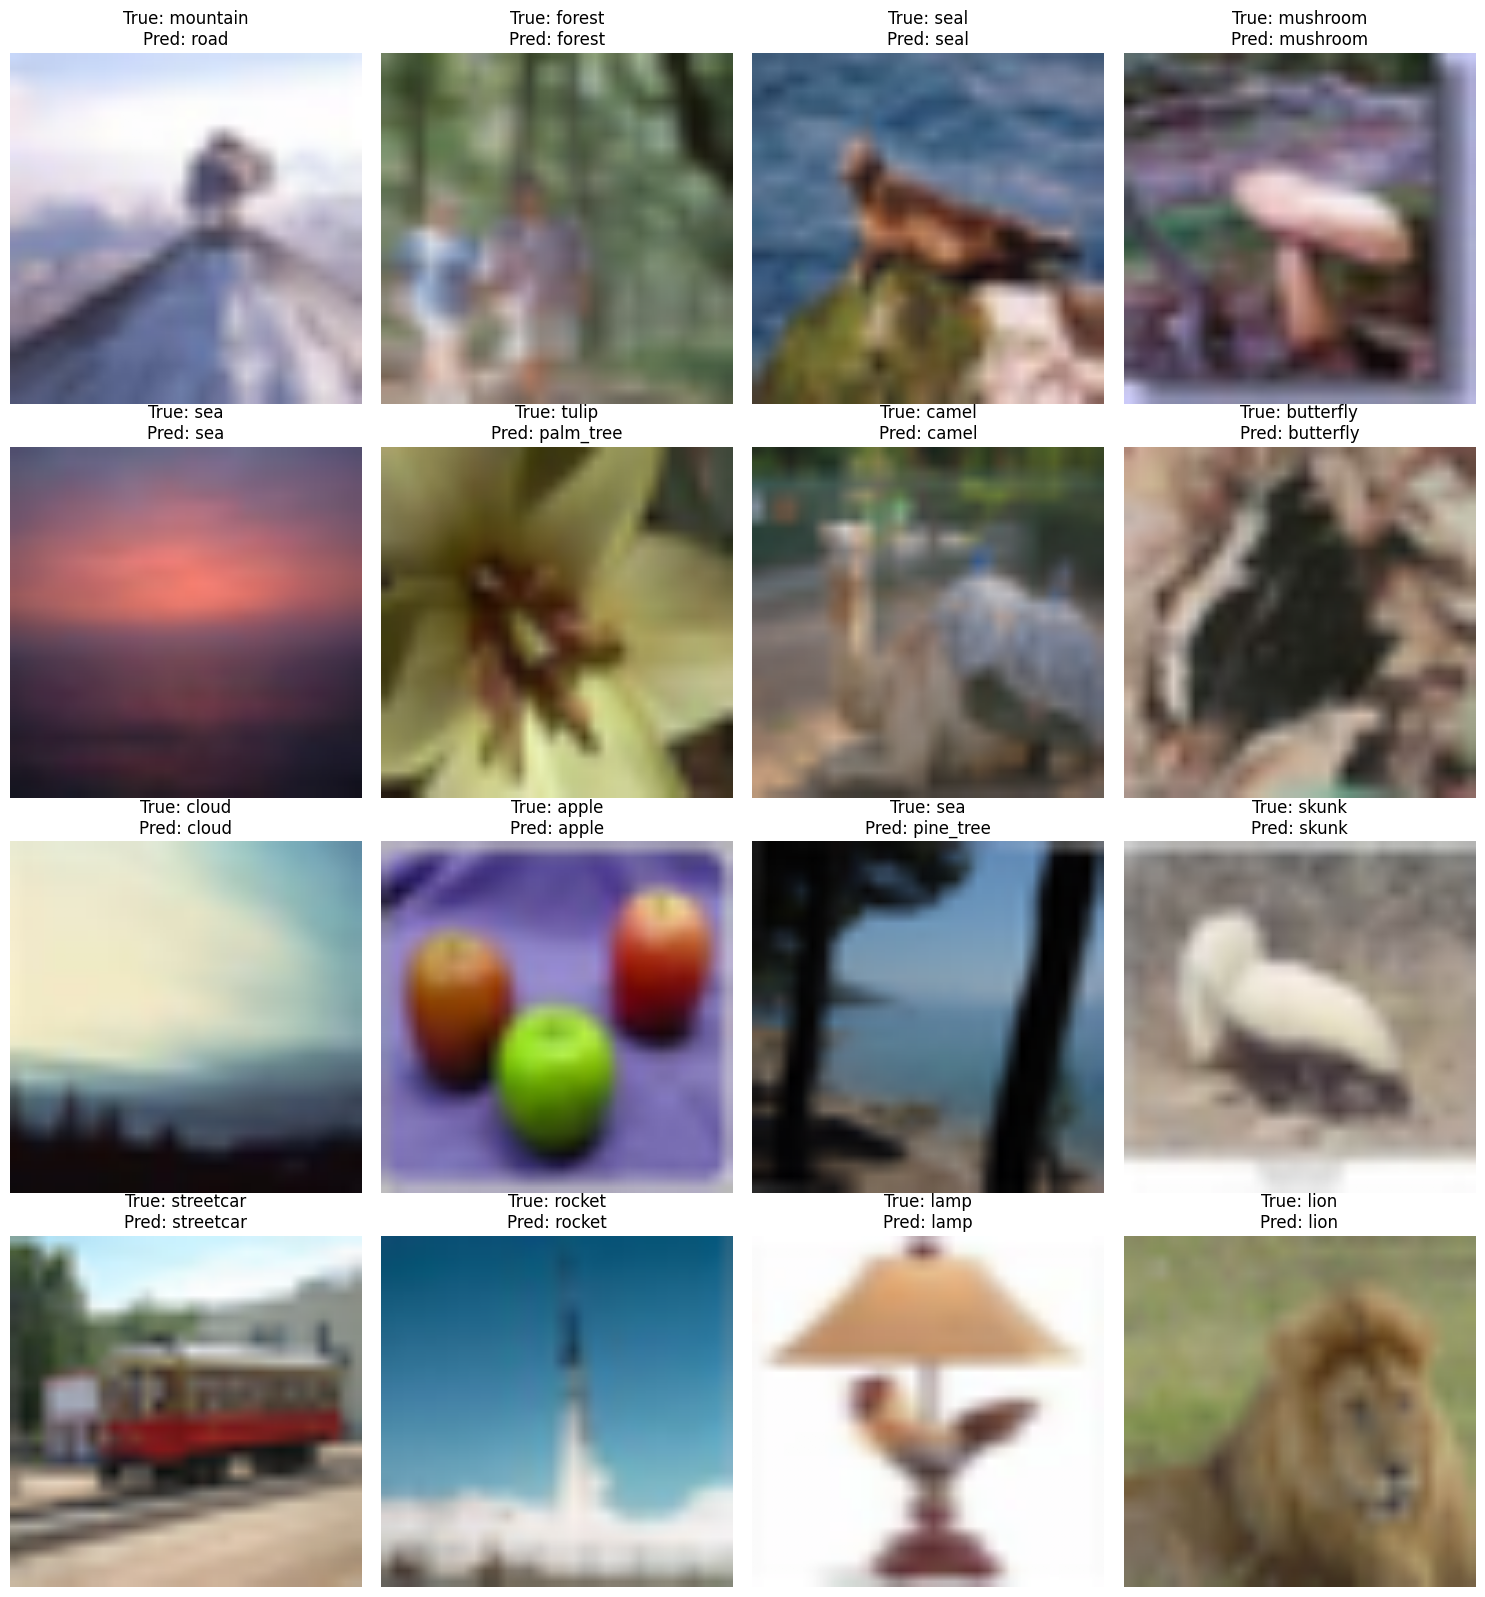

In [11]:
# определите метод денормализации
def denormalize(img_tensor):
    # Параметры нормализации, использованные при предобработке
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor.cpu() * std + mean

# получите батч и перенесите его на устройство
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
batch_size = images.size(0)

# получите прогнозные метки
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()

# постройте сетку отображения и визуализируйте каждое изображение с истинной и предсказанной метками
ncols = 4
nrows = (batch_size + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))
axes = axes.flatten()

for i in range(batch_size):
    img = denormalize(images[i]).cpu().permute(1, 2, 0).numpy()
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"True: {train_dataset.classes[true_labels[i]]}\nPred: {train_dataset.classes[predicted[i]]}")
    ax.axis('off')

# Если осей больше, чем изображений, скрываем лишние
for j in range(batch_size, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
